- **Nombre del candidato:** Juan Carlos Salazar Mesa
- **Fecha:** 08/08/2025
- **Email de contacto:** jucasamesa2@gmail.com

### Introducción

El equipo de Moderaciones IT (ModIT) dentro de Mercado Libre, se encarga de bloquear productos del marketplace que infringen políticas como derechos de autor, derechos de marca o aquellos cuyas imágenes no cumplen ciertos estándares de calidad. Estas bajas o moderaciones se pueden realizar manualmente o de forma automática, esta última siempre apoyada por modelos de Machine Learning que toman decisiones con base en los atributos (precio, marca, título, descripción, etc) y/o las imágenes de los productos.

Debido a que Mercado Libre tiene como prioridad en el 2022 el segmento de moda, ModIT está analizando todos los productos nuevos dentro del segmento de moda con el fin de moderar aquellos cuya imagen de portada no presente el producto en un fondo plano en color blanco o crema. Teniendo en cuenta que este trabajo está siendo realizado de forma manual por un equipo de 10 personas (moderadores) el análisis de ítems se limita a un total de 4,000 diarios. 

Ante esto nuestro equipo decide aceptar el reto y disparar un proceso de experimentación para identificar si podríamos o no generar algún recurso que apoye al equipo ModIT para automatizar el proceso y agregar valor a la experiencia laboral de los moderadores. 

A continuación te presentaremos 3 tareas comunes que nos enfrentamos como equipo al momento proponer una solución a algún problema planteado, para resolver cada una de ellas ten en cuenta los siguientes puntos:

1. Siéntete libre de realizar preguntas ante cualquier duda que se te presente. Estamos a un correo de distancia.
2. Los experimentos que realices deben ser replicables. Asegúrate de dejar disponible todo lo necesario para que podamos ejecutar tu código. Puedes usar archivos auxiliares como archivo de dependencias o scripts con funciones o clases.
3. Es importante que documentes lo que más puedas de tu código y dejes plasmado todas las ideas, procesos, experimentos, hipótesis y/o conclusiones que tuviste mientras estabas resolviendo el problema.
4. No esperamos una solución perfecta, para nosotros es más importante el proceso que planteas que el performance de la solución.

Mucha suerte!

### Parte I

Para el proceso de experimentación ModIT nos envía un archivo CSV (`training_data.csv`) con las siguientes columnas:
- **item_id:** Identificador único de item dentro del marketplace.
- **site_id:** País al que pertenece el ítem.
- **domain_id:** Categoría del marketplace a la que pertenece el ítem.
- **picture_id:** Identificador único de la imagen de portada del ítem. Con el *picture_id* podrás construir una url para descargar cada imagen, la estructura es la siguiente: https://http2.mlstatic.com/D_{picture_id}-F.jpg, e.g. http://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg
- **correct_background?:** 1 si el producto se presenta en un fondo apropiado, 0 de lo contrario.

En esta sección se requiere que realices los experimentos necesarios que permitan responder sí podemos o no dar solución al problema. 

In [1]:
import os
import cv2 as cv
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Para la parte I se utiliza el archivo `training_data.csv` para obtener las URLs y alimentar la función que procesa
import sys
from tqdm import tqdm

sys.path.append("../")

import pandas as pd
from src.data.preprocess import saving_images_in_local
from src.data.eda import analyze_all_images

In [3]:
path_csv_train = r"../data/raw/training_data.csv"
image_folder = r"../data/raw/img"

In [ ]:
# saving_images_in_local(path_csv_train, image_folder)

Reading CSV file: ../data/raw/training_data.csv
Found 4372 unique images to download
Images will be saved to: ../data/raw/img/
--------------------------------------------------
✓ Downloaded: D_820430-MLA49628611503_042022-F.jpg
✓ Downloaded: D_602874-CBT49608588342_042022-F.jpg
✓ Downloaded: D_727367-MLA49747205451_042022-F.jpg
✓ Downloaded: D_869404-MLB50031636104_052022-F.jpg
✓ Downloaded: D_888445-CBT50549726018_072022-F.jpg
✓ Downloaded: D_600362-MLM49679786269_042022-F.jpg
✓ Downloaded: D_614142-MLA50293545870_062022-F.jpg
✓ Downloaded: D_898807-MLM50081652397_052022-F.jpg
✓ Downloaded: D_635540-MLA49986649766_052022-F.jpg
✓ Downloaded: D_917336-MLB49987534769_052022-F.jpg
✓ Downloaded: D_663360-MLM45083915668_032021-F.jpg
✓ Downloaded: D_954888-MLA49129330330_022022-F.jpg
✓ Downloaded: D_638799-MLB48822254337_012022-F.jpg
✓ Downloaded: D_604564-CBT50286635097_062022-F.jpg
✓ Downloaded: D_712301-CBT50490005382_062022-F.jpg
✓ Downloaded: D_661960-MLA49628771060_042022-F.jpg
✓ Down

In [3]:
df, df2 = analyze_all_images(path_csv_train, image_folder)

Reading CSV file: ../data/raw/training_data.csv
Index(['item_id', 'site_id', 'domain_id', 'picture_id', 'correct_background?'], dtype='object')
Analyzing images...
--------------------------------------------------------------------------------
✗ D_820430-MLA49628611503_042022-F.jpg: dark (0.93) - Human: 0
✗ D_602874-CBT49608588342_042022-F.jpg: white (0.62) - Human: 1
✗ D_727367-MLA49747205451_042022-F.jpg: dark (0.87) - Human: 0
✗ D_869404-MLB50031636104_052022-F.jpg: white (0.71) - Human: ?
✗ D_888445-CBT50549726018_072022-F.jpg: white (0.66) - Human: 1
✗ D_600362-MLM49679786269_042022-F.jpg: pastel (0.58) - Human: ?
✗ D_614142-MLA50293545870_062022-F.jpg: white (0.64) - Human: 1
✗ D_898807-MLM50081652397_052022-F.jpg: pastel (0.45) - Human: 1
✗ D_635540-MLA49986649766_052022-F.jpg: dark (0.95) - Human: 0
✗ D_917336-MLB49987534769_052022-F.jpg: dark (0.94) - Human: ?
✗ D_663360-MLM45083915668_032021-F.jpg: dark (0.91) - Human: 0
✗ D_954888-MLA49129330330_022022-F.jpg: dark (0.70) - 

TypeError: cannot unpack non-iterable NoneType object

In [4]:
def load_image(image_path)->np.ndarray:
    """
    Load an image and convert to RGB format.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        numpy.ndarray: Image in RGB format, or None if loading fails
    """
    try:
        # Load image in BGR format (OpenCV default)
        img = cv.imread(image_path)
        if img is None:
            return None
        
        # Convert BGR to RGB
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        return img_rgb
    
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [ ]:
def analyze_background_color(image, threshold_percentage=0.3)->dict:
    """
    Analyze if the background is white or pastel colored.
    
    Args:
        image (numpy.ndarray): RGB image
        threshold_percentage (float): Percentage of pixels that need to be light to consider it light background
        
    Returns:
        dict: Analysis results including background type and confidence
    """
    if image is None:
        return {'background_type': 'unknown', 'confidence': 0.0, 'reason': 'Failed to load image'}
      
    # Get image dimensions
    height, width = image.shape[:2]
    total_pixels = height * width
    
    # Analyze different regions of the image (center, corners, edges)
    regions = {
        'center': image[height//4:3*height//4, width//4:3*width//4],
        'top_left': image[:height//3, :width//3],
        'top_right': image[:height//3, 2*width//3:],
        'bottom_left': image[2*height//3:, :width//3],
        'bottom_right': image[2*height//3:, 2*width//3:]
    }
    
    light_pixel_counts = {}
    white_pixel_counts = {}
    pastel_pixel_counts = {}
    
    for region_name, region in regions.items():
        if region.size == 0:
            continue
            
        # Convert region to different color spaces
        region_hsv = cv.cvtColor(region, cv.COLOR_RGB2HSV)
        region_lab = cv.cvtColor(region, cv.COLOR_RGB2LAB)
        
        # Define light color thresholds
        # Light colors: high value (V) in HSV, high lightness (L) in LAB
        light_mask = (region_hsv[:, :, 2] > 200) & (region_lab[:, :, 0] > 180)
        
        # White colors: very high value and low saturation
        white_mask = (region_hsv[:, :, 2] > 220) & (region_hsv[:, :, 1] < 30)
        
        # Pastel colors: medium-high value, low-medium saturation
        pastel_mask = (region_hsv[:, :, 2] > 180) & (region_hsv[:, :, 1] < 80) & (region_hsv[:, :, 2] <= 220)
        
        light_pixel_counts[region_name] = np.sum(light_mask)
        white_pixel_counts[region_name] = np.sum(white_mask)
        pastel_pixel_counts[region_name] = np.sum(pastel_mask)
    
    # Calculate overall percentages
    total_light_pixels = sum(light_pixel_counts.values())
    total_white_pixels = sum(white_pixel_counts.values())
    total_pastel_pixels = sum(pastel_pixel_counts.values())
    
    light_percentage = total_light_pixels / total_pixels if total_pixels > 0 else 0
    white_percentage = total_white_pixels / total_pixels if total_pixels > 0 else 0
    pastel_percentage = total_pastel_pixels / total_pixels if total_pixels > 0 else 0
    
    # Determine background type
    if white_percentage > threshold_percentage:
        background_type = 'white'
        confidence = min(white_percentage * 2, 1.0)  # Scale confidence
        reason = f"White pixels: {white_percentage:.2%}"
    elif light_percentage > threshold_percentage:
        background_type = 'pastel'
        confidence = min(light_percentage * 1.5, 1.0)  # Scale confidence
        reason = f"Light/pastel pixels: {light_percentage:.2%}"
    else:
        background_type = 'dark'
        confidence = 1.0 - light_percentage
        reason = f"Dark pixels: {1-light_percentage:.2%}"
    
    return {
        'background_type': background_type,
        'confidence': confidence,
        'reason': reason,
        'white_percentage': white_percentage,
        'pastel_percentage': pastel_percentage,
        'light_percentage': light_percentage
    }

In [6]:
def create_visualizations(results_df):
    """
    Create visualizations of the analysis results.
    
    Args:
        results_df (pandas.DataFrame): Results DataFrame
    """
    try:
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Background Analysis Results', fontsize=16, fontweight='bold')
        
        # 1. Confusion Matrix
        cm = confusion_matrix(results_df['human_annotation'], results_df['predicted_background'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Dark', 'Light'], yticklabels=['Dark', 'Light'],
                   ax=axes[0, 0])
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('Actual')
        
        # 2. Background Type Distribution
        type_counts = results_df['background_type'].value_counts()
        axes[0, 1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        axes[0, 1].set_title('Background Type Distribution')
        
        # 3. Confidence Distribution
        axes[1, 0].hist(results_df['confidence'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 0].set_title('Confidence Distribution')
        axes[1, 0].set_xlabel('Confidence Score')
        axes[1, 0].set_ylabel('Frequency')
        
        # 4. Accuracy by Background Type
        accuracy_by_type = results_df.groupby('background_type').apply(
            lambda x: accuracy_score(x['human_annotation'], x['predicted_background'])
        )
        axes[1, 1].bar(accuracy_by_type.index, accuracy_by_type.values, color='lightgreen')
        axes[1, 1].set_title('Accuracy by Background Type')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_ylim(0, 1)
        
        # Add value labels on bars
        for i, v in enumerate(accuracy_by_type.values):
            axes[1, 1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('background_analysis_plots.png', dpi=300, bbox_inches='tight')
        print("Visualizations saved to: background_analysis_plots.png")
        
    except Exception as e:
        print(f"Error creating visualizations: {e}")

In [7]:
df = pd.read_csv(path_csv_train, dtype=str)
df.shape

(4372, 5)

In [8]:
df['img_path'] = df['picture_id'].apply(lambda x: image_folder+f"/D_{x}-F.jpg")

In [39]:
image_path = df[df['img_path'].str.contains("600362-MLM49679786269_042022")]['img_path'].tolist()[0]
#df['img_path'][df['img_path'].sample(1, random_state=180).index[0]]

In [40]:
image_path

'../data/raw/img/D_600362-MLM49679786269_042022-F.jpg'

In [41]:
pil_image = Image.open(image_path)
cv_image = cv.cvtColor(np.array(pil_image), cv.COLOR_RGB2BGR)

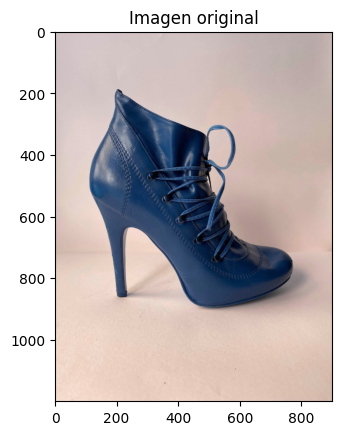

In [42]:
# Load image in BGR format (OpenCV default)
img = cv.imread(image_path)

plt.imshow(img)
plt.title('Imagen original')
plt.show()

In [44]:
array = load_image(image_path)

In [45]:
# Get array dimensions
height, width = array.shape[:2]
total_pixels = height * width

# Analyze different regions of the array (center, corners, edges)
regions = {
    'center': array[height//4:3*height//4, width//4:3*width//4],
    'top_left': array[:height//3, :width//3],
    'top_right': array[:height//3, 2*width//3:],
    'bottom_left': array[2*height//3:, :width//3],
    'bottom_right': array[2*height//3:, 2*width//3:]
    }

In [46]:
array.shape

(1200, 900, 3)

In [47]:
height, width, total_pixels

(1200, 900, 1080000)

In [29]:
regions['center'].shape, regions['top_left'].shape

((252, 122, 3), (167, 81, 3))

In [32]:
df['array'] = df['img_path'].apply(load_image)

In [ ]:
df['height'] = df['array'].apply(lambda x: x[0].shape[0])
df['width'] = df['array'].apply(lambda x: x[0].shape[0])
df['total_pixels'] = df['height']+df['width']

In [ ]:
df['total_pixels']

In [ ]:
height, width = array.shape[:2]
total_pixels = height * width

In [20]:
analyze_background_color(array)

{'background_type': 'white',
 'confidence': np.float64(0.748068963269563),
 'reason': 'White pixels: 37.40%',
 'white_percentage': np.float64(0.3740344816347815),
 'pastel_percentage': np.float64(0.002354724114330411),
 'light_percentage': np.float64(0.3753299872893785)}

In [ ]:
def analyze_all_images(csv_filename="data.csv", images_folder="images")->pd.DataFrame:
    """
    Analyze all images and compare with human annotations.
    
    Args:
        csv_filename (str): Path to the CSV file
        images_folder (str): Path to the images folder
    """
    # Check if files exist
    if not os.path.exists(csv_filename):
        print(f"Error: CSV file '{csv_filename}' not found!")
        return
    
    if not os.path.exists(images_folder):
        print(f"Error: Images folder '{images_folder}' not found!")
        return
    
    try:
        # Read CSV file
        print(f"Reading CSV file: {csv_filename}")
        df = pd.read_csv(csv_filename)
        print(df.columns)
        
        # Check if required columns exist
        required_columns = ['item_id', 'site_id', 'domain_id', 'picture_id', 'correct_background?']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"Error: Missing required columns: {missing_columns}")
            return
        
        # Initialize results
        results = []
        analyzed_count = 0
        missing_images = 0
        
        print("Analyzing images...")
        print("-" * 80)
        
        for index, row in df.iterrows():
            picture_id = row['picture_id']
            correct_background = row['correct_background?']
            
            # Skip if picture_id is NaN or empty
            if pd.isna(picture_id) or str(picture_id).strip() == '':
                continue
            
            # Construct image path
            image_filename = f"D_{picture_id}-F.jpg"
            image_path = os.path.join(images_folder, image_filename)
            
            # Check if image exists
            if not os.path.exists(image_path):
                print(f"⚠  Missing image: {image_filename}")
                missing_images += 1
                continue
            
            # Load and analyze image
            image = load_image(image_path)
            analysis = analyze_background_color(image)
            
            # Determine predicted background (True for white/pastel, False for dark)
            predicted_background = analysis['background_type'] in ['white', 'pastel']
            
            # Store results
            result = {
                'item_id': row['item_id'],
                'picture_id': picture_id,
                'image_filename': image_filename,
                'human_annotation': correct_background,
                'predicted_background': predicted_background,
                'background_type': analysis['background_type'],
                'confidence': analysis['confidence'],
                'reason': analysis['reason'],
                'white_percentage': analysis['white_percentage'],
                'pastel_percentage': analysis['pastel_percentage'],
                'light_percentage': analysis['light_percentage']
            }
            results.append(result)
            
            # Print progress
            status = "✓" if predicted_background == correct_background else "✗"
            print(f"{status} {image_filename}: {analysis['background_type']} ({analysis['confidence']:.2f}) - Human: {correct_background}")
            
            analyzed_count += 1
        
        # Create results DataFrame
        results_df = pd.DataFrame(results)

        results_df2 = results_df.copy()
        
        # Calculate metrics
        if len(results_df) > 0:
            accuracy = accuracy_score(results_df['human_annotation'], results_df['predicted_background'])
            
            print("\n" + "=" * 80)
            print("ANALYSIS RESULTS")
            print("=" * 80)
            print(f"Total images analyzed: {analyzed_count}")
            print(f"Missing images: {missing_images}")
            print(f"Overall accuracy: {accuracy:.2%}")
            
            # Detailed classification report
            print("\nClassification Report:")
            print(classification_report(results_df['human_annotation'], results_df['predicted_background'], 
                                     target_names=['Dark Background', 'Light Background']))
            
            # Background type distribution
            print("\nBackground Type Distribution:")
            type_counts = results_df['background_type'].value_counts()
            for bg_type, count in type_counts.items():
                print(f"  {bg_type}: {count} ({count/len(results_df):.1%})")
            
            # Confidence analysis
            print(f"\nAverage confidence: {results_df['confidence'].mean():.2f}")
            print(f"Confidence range: {results_df['confidence'].min():.2f} - {results_df['confidence'].max():.2f}")
            
            # Save detailed results
            output_filename = "../../data/processed/background_analysis_results.csv"
            results_df.to_csv(output_filename, index=False)
            print(f"\nDetailed results saved to: {output_filename}")
            
            # Create visualizations
            create_visualizations(results_df)
        
            return results_df2, results_df2

        else:
            print("No images were successfully analyzed!")
            
    except Exception as e:
        print(f"Error during analysis: {e}")

NameError: name 'df' is not defined

### Parte II

Con el fin de evaluar la solución, se nos hace llegar un nuevo dataset (`productive_data.csv`) con los últimos 5,800 ítems revisados por el equipo de moderadores. La idea en esta parte es que realices una evaluación de tu propuesta y nos hagas saber si estaría lista para puesta en producción. **Nota:** Recuerda que en Mercado Libre trabajamos codo a codo para alcanzar nuestros objetivos así que cualquier duda o solicitud con gusto será atendida por tus compañeros de equipo o stakeholders.

### Parte III

Debido al gran volumen de ítems que procesamos día a día, algún error en nuestras soluciones podría llegar a afectar muchos vendedores y generar malas experiencias de usuario en el marketplace. Con lo cual, solemos penalizar bastante los errores de clasificación que involucren bajas erróneas de ítems. Como última tarea, te proponemos plantear un proceso que nos permita maximizar la precisión de tu solución con base a los datos que tienes disponibles hasta el momento.